<a href="https://colab.research.google.com/github/VhinyMombo/Boltzmann-Machine/blob/main/Ising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Model Ising

In [1]:
#%%writefile -a IsingModel.py
from gzip import READ
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.datasets import mnist

class IsingModel():
  def __init__(self,n,p,beta,nb_cycle,prob = 0.5):
    self._n = 50
    self._p = p
    self._proba = prob
    self.nb_cycle = nb_cycle
    self.beta = beta
    

  def __get_neighbours2(self, i,j):
    u = 1 if i+1 > self._n-1 else i+1
    a = self._n-1 if i-1 < 0 else i-1
    l = self._p-1 if j-1 < 0 else j-1
    r = 1 if j+1 > self._p-1 else j+1

    neighoors_coord = np.array([u,l,u,r,a,l,a,r]).reshape([4,2])
    return neighoors_coord

  def  get_params(self):
    
    return {'n' : self._n,
            'p' : self._p,
            'proba' : self._proba,
            'beta' : self.beta,
            'nb_cycle' : self.nb_cycle}

  def __update(self, i,j,mat2):
    sum_N_index= sum([mat2[k[0],k[1]] for k in self.__get_neighbours2(i,j)])

    pX_ij_cond_Nij  = 1/(1+np.exp(-2*self.beta * sum_N_index))
    
    mat2[i,j] = 2 * np.random.binomial(1,pX_ij_cond_Nij,1)-1
    return mat2.reshape(self._n,self._p).T

  def __call__(self):
    cycle = 1
    mat  = ((2 * np.random.binomial(1,self._proba,self._n * self._p)-1)
    .reshape([self._n, self._p]))
    mat2 = mat.copy()

    for cycle in tqdm(range(self.nb_cycle), desc ="epochs"):
      cycle+=1
      #print(cycle)
      walk_order = random.sample(list(range(self._n*self._p)),self._n*self._p)
      for i in range(self._n):
        for j in range(self._p):
          mat2 = self.__update(i,j,mat2)    
    return mat2



epochs: 100%|██████████| 100/100 [00:07<00:00, 13.70it/s]


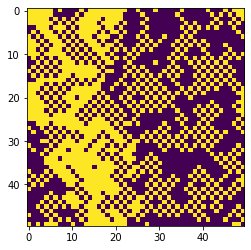

In [2]:
#%%writefile -a main.py
n = 50
p =  50
prob = 0.5
beta = 10
nb_cycle = 100
model = IsingModel(n,p,beta, nb_cycle,prob)
plt.imshow(model())
plt.show()

In [ ]:
model.get_params()

{'beta': 3, 'n': 50, 'nb_cycle': 100, 'p': 50, 'proba': 0.5}

In [ ]:
n = 1
p = 0.5
s = 2*np.random.binomial(1, p, 1)-1
s

array([1])

In [17]:
%%writefile -a Boltzmann.py

class BoltzmannModel(IsingModel):
  def __init__(self,n,p,beta, nb_cycle,prob,input_size, n_hidden_unit, eps = 1e-3):
    super().__init__(n,p,beta,nb_cycle,prob)
    self._input_size = input_size
    self._n_hidden_unit = n_hidden_unit
    self._W = np.random.random([n_hidden_unit,input_size])
    self._eps = eps 

  def  get_params(self):
    
    return {'n' : self._n,
            'p' : self._p,
            'proba' : self._proba,
            'beta' : self.beta,
            'nb_cycle' : self.nb_cycle,
            'input_size' : self._input_size,
            'n_hidden_unit' : self._n_hidden_unit,
            'eps' : self._eps}

  def __simul(self, v):
    cycle = 1
    mat  = ((2 * np.random.binomial(1,self._proba,len(x))-1)
    .reshape([self._n, self._p]))
    mat2 = mat.copy()

    while(cycle <= self.nb_cycle):
      cycle+=1
      #print(cycle)
      #walk_order = random.sample(list(range(self._n*self._p)),self._n*self._p)
      for i in range(self._n):
        for j in range(self._p):
          mat2 = self.__update(i,j,mat2)    
    return mat2

  def _forward(self,x):
    x = x.flatten()
    h = np.random.random(self._n_hidden_unit)
    #pX_ij_cond_Nij  = 1/(1+np.exp(-2*self.beta * sum_N_index))
    bias = np.random.random(self._n_hidden_unit)
    #print(f'bias : {bias}')
    #print(f'w*x : {self._W.dot(x)}')
    #print(self._W)
    p_h_v = 1/(1+np.exp(-(bias + self._W.dot(x))))
    #print(p_h_v)
    h = np.array([np.random.binomial(1,p_h_v[i],1)[0] for i in range(len(p_h_v))])
    return h
  
  def _update_w(self, v,h,v2,h2):
    W = np.array([list(i*h) for i in v])
    W2 = np.array([list(i*h2) for i in v2])
    DW = self._eps * (W-W2).T
    self._W+=DW

  def _backward(self, h):
    bias =np.random.random(self._input_size)
    p_v_h = 1/(1+np.exp(-(bias + h.T.dot(self._W))))
    v = np.array([np.random.binomial(1,p_v_h[i],1)[0] for i in range(len(p_v_h))])
    return v

  def get_w(self):
    return(self._W)

  def forward(self,v):
    v = v.flatten()
    v = (v-v.mean())/v.std()
    for cycle in tqdm(range(self.nb_cycle), desc ="epochs"):
      h = self._forward(v)
      #print(f'h = {h}')
      print(np.linalg.norm(self._W))
      v_prime = self._backward(h)
      h_prime = self._forward(v_prime)
      self._update_w(v,h,v_prime,h_prime)
    return self._W

Writing Boltzmann.py


In [13]:
w = np.random.random([2,5]) # é
x = np.random.binomial(1,0.5,5)
bias = np.random.random(2)
prob = 1/(1+np.exp(-(bias + w.dot(x))))
h =  np.array([np.random.binomial(1,prob[i],1)[0] for i in range(len(prob))])

print(f'x = {x}')
print(f'w = {w}')
print(f'w*x = {w.dot(x)}')
print(f'proba = {prob}')
print(f'h = {h}')


x = [0 1 0 0 1]
w = [[0.89950634 0.55473352 0.27317125 0.8051774  0.74654608]
 [0.96630435 0.24392811 0.34432533 0.17134072 0.3258481 ]]
w*x = [1.30127961 0.5697762 ]
proba = [0.87079247 0.82729931]
h = [1 1]


In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [5]:
input_size = x_train[0].flatten().shape[0]
n_hidden_unit = 50
model2 = BoltzmannModel(n,p,beta, nb_cycle,prob,input_size, n_hidden_unit)

In [6]:
model2.get_params()

{'beta': 10,
 'eps': 0.001,
 'input_size': 784,
 'n': 50,
 'n_hidden_unit': 50,
 'nb_cycle': 100,
 'p': 50,
 'proba': 0.5}

In [7]:
x = (x_train[0]-x_train[0].mean())/x_train[0].std()

### Matrice des poids

epochs:   3%|▎         | 3/100 [00:00<00:03, 27.07it/s]

114.40184906167977
114.23194875998745
114.06232204864732
113.89299945442275
113.72397258613431
113.55518917005324


epochs:   9%|▉         | 9/100 [00:00<00:03, 26.19it/s]

113.38672396619427
113.21855348408236
113.0506896976035
112.88314531515601
112.71588794982915


epochs:  15%|█▌        | 15/100 [00:00<00:03, 25.09it/s]

112.54896054378453
112.38233245232158
112.21602678669669
112.05006027827068
111.88437626275622
111.71903832819038


epochs:  21%|██        | 21/100 [00:00<00:03, 23.77it/s]

111.55406620161367
111.3894361413417
111.22512938732842
111.0611954571275
110.89756171579079


epochs:  24%|██▍       | 24/100 [00:01<00:03, 21.88it/s]

110.73432520969257
110.57143446201583
110.40890873532894
110.2467389969794
110.08493571243076


epochs:  29%|██▉       | 29/100 [00:01<00:04, 15.30it/s]

109.92346075426802
109.76239517948306


epochs:  31%|███       | 31/100 [00:01<00:04, 13.90it/s]

109.60170093059196
109.44129133199542
109.28134451843373


epochs:  33%|███▎      | 33/100 [00:01<00:05, 13.16it/s]

109.1217739550568
108.96255803686904
108.8037449046675


epochs:  35%|███▌      | 35/100 [00:01<00:05, 12.63it/s]

108.64531299886741
108.48726398966735


epochs:  37%|███▋      | 37/100 [00:02<00:05, 10.96it/s]

108.32959955296471
108.17232137033761


epochs:  41%|████      | 41/100 [00:02<00:05, 11.75it/s]

108.01543112902668
107.85893052191561
107.70282124751108
107.5471050099222


epochs:  45%|████▌     | 45/100 [00:02<00:04, 13.00it/s]

107.39176722102479
107.23683315770899
107.08230627436178


epochs:  49%|████▉     | 49/100 [00:03<00:03, 14.29it/s]

106.92817929983717
106.77445396591845
106.62113030051582
106.46821911443392


epochs:  51%|█████     | 51/100 [00:03<00:04, 11.89it/s]

106.31572218744813
106.16362086694558


epochs:  53%|█████▎    | 53/100 [00:03<00:04, 10.03it/s]

106.0119299273552
105.86067162908996
105.70980080694848


epochs:  58%|█████▊    | 58/100 [00:03<00:02, 14.78it/s]

105.55938704579646
105.40939829220068
105.25983636298955
105.11070308014723
104.96200027077616
104.81372976705843


epochs:  64%|██████▍   | 64/100 [00:04<00:01, 19.38it/s]

104.66589340621657
104.51849303047298
104.37153048700858
104.22500762792056
104.07892631017886
103.9332883955818


epochs:  70%|███████   | 70/100 [00:04<00:01, 22.60it/s]

103.78809575071081
103.64332322171764
103.499026697264
103.3551810705226
103.21178822673332
103.06883048644127


epochs:  76%|███████▌  | 76/100 [00:04<00:00, 24.09it/s]

102.92634885529701
102.7843136940896
102.64274650674413
102.50164923224627
102.36102381381872


epochs:  82%|████████▏ | 82/100 [00:04<00:00, 24.15it/s]

102.22087219886104
102.08119633888798
101.9419981894671
101.80327971015487
101.66504286443175
101.52728961963608


epochs:  88%|████████▊ | 88/100 [00:04<00:00, 25.34it/s]

101.39002194689664
101.25324182106417
101.11695122064158
100.98115212771307
100.84584652787169
100.71103641014605


epochs:  94%|█████████▍| 94/100 [00:05<00:00, 25.85it/s]

100.5767237669257
100.44291059388507
100.3095988899064
100.17679065700112
100.04448790023038
99.91269262762395


epochs: 100%|██████████| 100/100 [00:05<00:00, 18.31it/s]

99.78140685009795
99.65063258137147
99.52037183788157
99.3906266386973


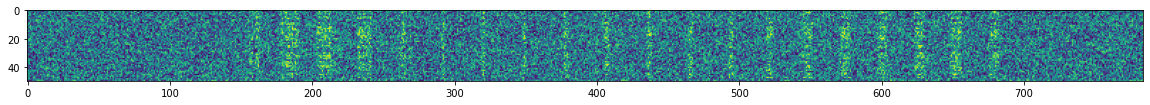

In [8]:
input_size = x_train[0].flatten().shape[0]
n_hidden_unit = 50
model2 = BoltzmannModel(n,p,beta, nb_cycle,prob,input_size, n_hidden_unit)
W0 = model2.get_w()
plt.figure(figsize=(20,50))
model2.forward(x_train[0])
W1 = model2.get_w()
plt.imshow(W1)
plt.show()

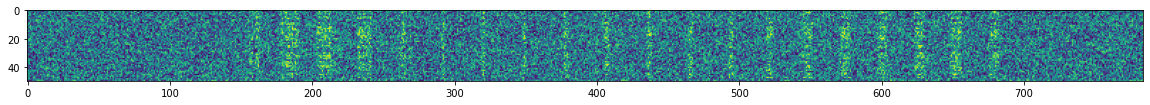

In [14]:
plt.figure(figsize=(20,50))
plt.imshow(W1)
plt.show()

epochs: 100%|██████████| 100/100 [00:03<00:00, 26.66it/s]


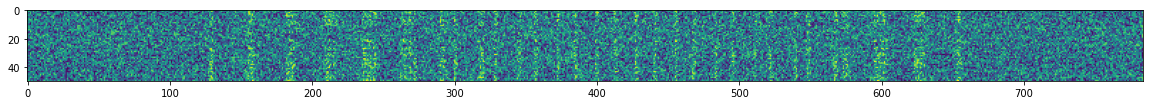

In [65]:
input_size = x_train[1].flatten().shape[0]
n_hidden_unit = 50
model2 = BoltzmannModel(n,p,beta, nb_cycle,prob,input_size, n_hidden_unit)

plt.figure(figsize=(20,50))
plt.imshow(model2.forward(x_train[1]))
plt.show()

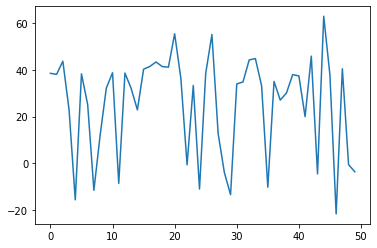

In [16]:
y = x_train[1].flatten()
y = (y-y.mean())/y.std()

plt.plot(model2.get_w().dot(y))